In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_swiss_roll
from matplotlib.animation import FuncAnimation

In [2]:
n_samples=1_000

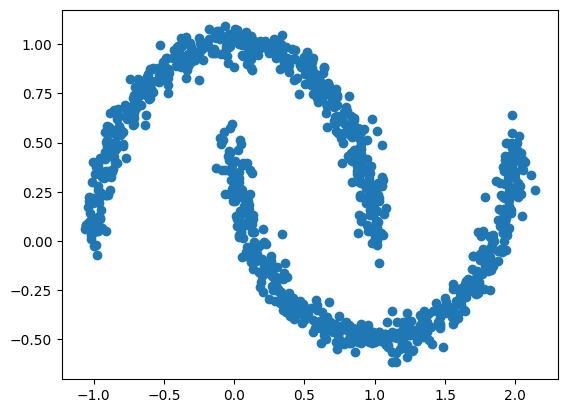

In [3]:
data, _ = make_moons(n_samples=n_samples, noise=0.05)
# data, _ = make_swiss_roll(n_samples, noise=1)
fig=plt.scatter(data[:,0], data[:,1])

In [4]:
class FlowMatching(keras.Model):
    def __init__(self, n_units, n_layers, dim=2):
        super(FlowMatching, self).__init__()
        self.dim = dim
        self.velocity = keras.Sequential(
            [keras.layers.Dense(n_units, activation="elu") for _ in range(n_layers)]
            )
        self.velocity.add(keras.layers.Dense(dim))

    def call(self, inputs):
        x_0, x_1, t = inputs.values()
        x_t = (1-t)*x_0 + t*x_1
        x = keras.ops.concatenate([x_t, t], axis=-1)
        return self.velocity(x)

    def step(self, x, t, dt):
        t_start = np.zeros_like(x) + t
        input_start = keras.ops.concatenate([x, t_start], axis=-1)
        v = self.velocity(input_start)
        x_mid = x + v * dt / 2

        t_mid = t_start + dt / 2
        input_mid = keras.ops.concatenate([x_mid, t_mid], axis=-1)
        v = self.velocity(input_mid)
        x_end = x + v * dt

        return x_end

    def run(self, x, steps):
        time = np.linspace(0, 1, steps+1)
        output = []
        output.append(x)
        for i in range(steps):
            x = self.step(x, time[i], time[i+1]-time[i])
            output.append(x)
        
        return output

    def sample(self, n_samples, steps):
        x_0 = np.random.normal(size=(n_samples, self.dim))
        x_1 = self.run(x_0, steps)
        return np.array(x_1).swapaxes(0, 1)
        
        

In [5]:
flow = FlowMatching(n_units=64, n_layers=3)

In [6]:
class DataSet(keras.utils.PyDataset):
    def __init__(self, batch_size, n_batches):
        super().__init__()
        self.n_batches=n_batches
        self.batch_size = batch_size
    
    @property
    def num_batches(self):
        return self.n_batches

    def __getitem__(self, index):
        data, _ = make_moons(n_samples=self.batch_size, noise=0.05)
        base = np.random.normal(size=data.shape)
        t = np.random.uniform(low=0, high=1, size=data.shape[0])
        t = np.repeat(t[:,np.newaxis], repeats=data.shape[1], axis=1)

        target = data - base
        return dict(x_0=base, x_1=data, t=t), target

In [7]:
def get_lr(optimizer):
    def lr(*args, **kwargs):
        return optimizer.learning_rate
    return lr

In [ ]:
epochs=10
batches=1000
batch_size=512

dataset=DataSet(batch_size=batch_size, n_batches=epochs*batches)

schedule = keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.01, decay_steps=epochs*batches)
optimizer = keras.optimizers.Adam(schedule, global_clipnorm=1.0)
lr_metric = get_lr(optimizer)

flow.compile(
    optimizer=optimizer,
    metrics=[lr_metric],
    loss=keras.losses.MeanSquaredError()
)

In [9]:
history=flow.fit(x=dataset, epochs=epochs, steps_per_epoch=batches)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1063 - lr: 0.0100
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0081 - lr: 0.0100
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9997 - lr: 0.0100
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9874 - lr: 0.0100
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9829 - lr: 0.0100
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9776 - lr: 0.0100
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9739 - lr: 0.0100
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9677 - lr: 0.0100
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9662 - lr: 0.0100
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9632 - lr: 0.0100


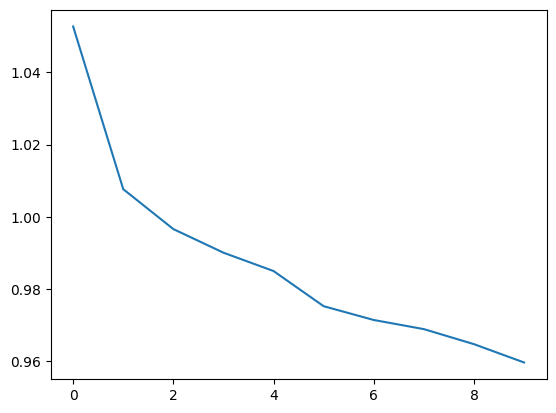

In [10]:
f=plt.plot(history.history["loss"])

In [11]:
x = flow.sample(n_samples=n_samples, steps=100)

(-3.0, 3.0)

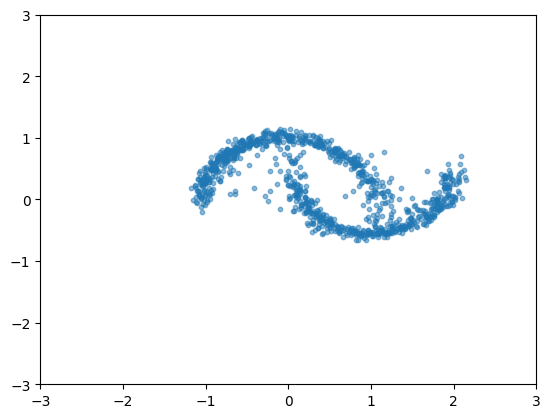

In [12]:
f=plt.scatter(x[:, -1, 0], x[:, -1, 1], s=10, alpha=0.5)
plt.xlim(-3, 3)
plt.ylim(-3, 3)

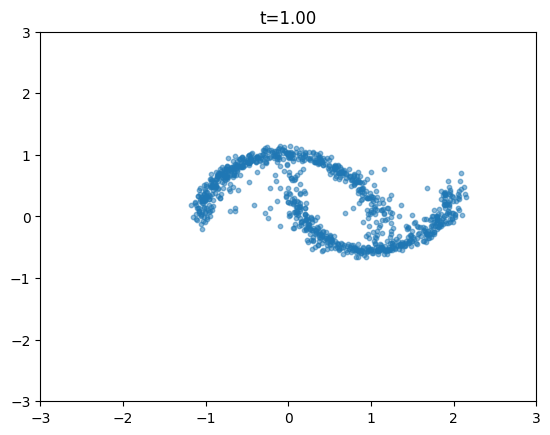

In [13]:
fig, ax = plt.subplots()

def animate(i):
    fig.clear()
    ax = fig.add_subplot()
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    t = np.linspace(0, 1, x.shape[1])[i]
    ax.set_title("t={0:.2f}".format(t))
    s = ax.scatter(x[:,i,0], x[:,i,1], s=10, alpha=0.5)

animation = FuncAnimation(fig, animate, interval=50, frames=range(x.shape[1]))
animation.save("flow-matching-moons.mp4", writer="ffmpeg")
plt.show()